In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import numpy as np
import tpot as tp
import imblearn
from collections import Counter
from tpot import TPOTClassifier
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN 
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
sns.set()

In [136]:
bc2.isnull().sum()

Clump Thickness                  0
Uniformity of Cell Size          0
Uniformity of Cell Shape         0
Marginal Adhesion                0
Single Epithelial Cell Size      0
Bare Nuclei                      0
Bland Chromatin                  0
Normal Nucleoli                  0
Mitosis                          0
Class                            0
radius                         130
mean_radius                    130
texture                        130
mean_texture                   130
perimeter                      130
mean_perimeter                 130
area                           130
mean_area                      130
smoothness                     130
mean_smoothness                130
compactness                    130
mean_compactness               130
concavity                      130
mean_concavity                 130
concave_points                 130
mean_concave_points            130
symmetry                       130
mean_symmetry                  130
fractal_dimension   

In [137]:
bc2 = pd.read_csv('bc_data.csv', header = [1])
bc2.drop(['Diagnosis','id_number.1'], axis = 1, inplace = True)
bc2.set_index('id_number', inplace = True)
bc_data_with_dummies = pd.get_dummies(bc2)

In [138]:
bc_data_full = bc_data_with_dummies.interpolate(method = 'linear',axis = 1)

In [139]:
bc_data_full.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitosis,Class,radius,...,Bare Nuclei_10,Bare Nuclei_2,Bare Nuclei_3,Bare Nuclei_4,Bare Nuclei_5,Bare Nuclei_6,Bare Nuclei_7,Bare Nuclei_8,Bare Nuclei_9,Bare Nuclei_?
id_number,,,,,,,,,,,,,,,,,,,,,
1000025,5.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,2.0,17.99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002945,5.0,4.0,4.0,5.0,7.0,3.0,2.0,1.0,2.0,20.57,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1015425,3.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,2.0,19.69,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1016277,6.0,8.0,8.0,1.0,3.0,3.0,7.0,1.0,2.0,11.42,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1017023,4.0,1.0,1.0,3.0,2.0,3.0,1.0,1.0,2.0,20.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
bc_data_full.columns

Index(['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bland Chromatin', 'Normal Nucleoli',
       'Mitosis', 'Class', 'radius', 'mean_radius', 'texture', 'mean_texture',
       'perimeter', 'mean_perimeter', 'area', 'mean_area', 'smoothness',
       'mean_smoothness', 'compactness', 'mean_compactness', 'concavity',
       'mean_concavity', 'concave_points', 'mean_concave_points', 'symmetry',
       'mean_symmetry', 'fractal_dimension', 'mean_fractal_dimension',
       'Bare Nuclei_1', 'Bare Nuclei_10', 'Bare Nuclei_2', 'Bare Nuclei_3',
       'Bare Nuclei_4', 'Bare Nuclei_5', 'Bare Nuclei_6', 'Bare Nuclei_7',
       'Bare Nuclei_8', 'Bare Nuclei_9', 'Bare Nuclei_?'],
      dtype='object')

In [75]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [167]:
#split into training and testing set
features = ['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bland Chromatin', 'Normal Nucleoli',
       'Mitosis', 'radius', 'mean_radius', 'texture', 'mean_texture',
       'perimeter', 'mean_perimeter', 'area', 'mean_area', 'smoothness',
       'mean_smoothness', 'compactness', 'mean_compactness', 'concavity',
       'mean_concavity', 'concave_points', 'mean_concave_points', 'symmetry',
       'mean_symmetry', 'fractal_dimension', 'mean_fractal_dimension',
       'Bare Nuclei_1', 'Bare Nuclei_10', 'Bare Nuclei_2', 'Bare Nuclei_3',
       'Bare Nuclei_4', 'Bare Nuclei_5', 'Bare Nuclei_6', 'Bare Nuclei_7',
       'Bare Nuclei_8', 'Bare Nuclei_9', 'Bare Nuclei_?']
X = bc_data_full[features]
y = bc_data_full['Class']
features_train,features_test,target_train,target_test = train_test_split(X,y, test_size = .25, random_state = 1 )

In [168]:
#Standardization before applying PCA
scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)
print(X_train)

[[ 1.24812634 -0.05678383  0.24996077 ... -0.18311355 -0.09815249
  -0.15309311]
 [ 1.24812634  0.59716622  0.92165021 ... -0.18311355 -0.09815249
  -0.15309311]
 [ 1.24812634  1.5780913   1.92918438 ... -0.18311355 -0.09815249
  -0.15309311]
 ...
 [-1.24676599 -0.05678383 -0.08588396 ... -0.18311355 -0.09815249
  -0.15309311]
 [-0.53393961 -0.71073388  0.24996077 ... -0.18311355 -0.09815249
   6.53197265]
 [ 0.53529996 -0.38375886 -0.7575734  ... -0.18311355 -0.09815249
  -0.15309311]]


In [169]:
pca_columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21','PC22','PC23','PC24','PC25','PC26','PC27','PC28','PC29']

In [170]:
#Fitting training PCA
pca = PCA(n_components=29)
X_train_pca = pca.fit_transform(X_train)
principalDF = pd.DataFrame(data = X_train_pca, columns = pca_columns )
print("original shape:   ", X_train.shape)
print("transformed shape:", X_train_pca.shape)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

#plot_2d_space(pca_result, y, ' 29 PCA components')

original shape:    (524, 39)
transformed shape: (524, 29)
Explained variation per principal component: [3.82495575e-01 1.62986727e-01 7.33323720e-02 3.24405923e-02
 3.02020595e-02 2.95677102e-02 2.80801540e-02 2.73948168e-02
 2.67846394e-02 2.65584993e-02 2.63982703e-02 2.61352166e-02
 2.30229296e-02 1.93696049e-02 1.49190850e-02 1.28478226e-02
 1.16281071e-02 9.96021439e-03 8.31837721e-03 7.86937974e-03
 6.29411037e-03 6.07289501e-03 3.41449257e-03 2.02799630e-03
 1.31842518e-03 2.28791684e-04 1.59863683e-04 1.00025535e-04
 2.62971797e-05]


In [166]:
fitting testing PCA
X_test_pca = pca.fit_transform(features_test)
testprincipalDF = pd.DataFrame(data = X_test_pca, columns = pca_columns)
print("original shape:   ", features_test.shape)
print("transformed shape:", X_test_pca.shape)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))



In [185]:
print(len(principalDF))
print(len(testprincipalDF))


524
210


In [172]:
eig_values = pca.explained_variance_
eig_vectors = pca.components_
print(eig_values)
print(eig_vectors)

[1.49458500e+01 6.36863625e+00 2.86543089e+00 1.26760219e+00
 1.18013248e+00 1.15534556e+00 1.09721994e+00 1.07044068e+00
 1.04659826e+00 1.03776193e+00 1.03150106e+00 1.02122235e+00
 8.99611069e-01 7.56858980e-01 5.82956828e-01 5.02023139e-01
 4.54363284e-01 3.89191092e-01 3.25037011e-01 3.07492628e-01
 2.45939655e-01 2.37295760e-01 1.33419828e-01 7.92430829e-02
 5.15168968e-02 8.93993663e-03 6.24660464e-03 3.90845476e-03
 1.02755098e-03]
[[-0.03448161 -0.01618502 -0.01963067 ... -0.01150041 -0.01240028
  -0.01925216]
 [ 0.294239    0.36416576  0.36097177 ...  0.09286093  0.0410768
  -0.0114732 ]
 [-0.03481445 -0.00694735  0.01312034 ... -0.01006279 -0.05810507
  -0.03168157]
 ...
 [ 0.00105181 -0.01763708  0.00376703 ... -0.00067354 -0.0025298
   0.00406315]
 [-0.00165534 -0.00850393  0.00826052 ... -0.0021773  -0.00373302
   0.0043426 ]
 [-0.00221506 -0.00148192  0.00097179 ...  0.00123651  0.00141878
  -0.00086797]]


In [173]:
eig_vectors[0]

array([-3.44816080e-02, -1.61850195e-02, -1.96306715e-02, -2.14039651e-02,
       -3.29266540e-02, -1.90207615e-02, -2.81563719e-02, -3.03333226e-02,
       -2.25816199e-01, -2.26321678e-01, -2.31989075e-01, -1.82604589e-01,
        2.44379468e-01,  2.44574703e-01,  2.44427861e-01,  2.47895346e-01,
        2.49654024e-01,  2.52344840e-01,  2.07005343e-01,  5.72898216e-02,
       -9.32807639e-02, -1.06756039e-01,  2.56174311e-01,  2.54575382e-01,
        2.51436300e-01,  2.47957463e-01,  2.40852348e-01,  2.31358329e-01,
        5.23473100e-02, -3.91018972e-02,  2.09141720e-04, -1.18639542e-02,
       -2.83827295e-03, -2.08781206e-03,  1.34971963e-02, -1.61976600e-02,
       -1.15004149e-02, -1.24002757e-02, -1.92521577e-02])

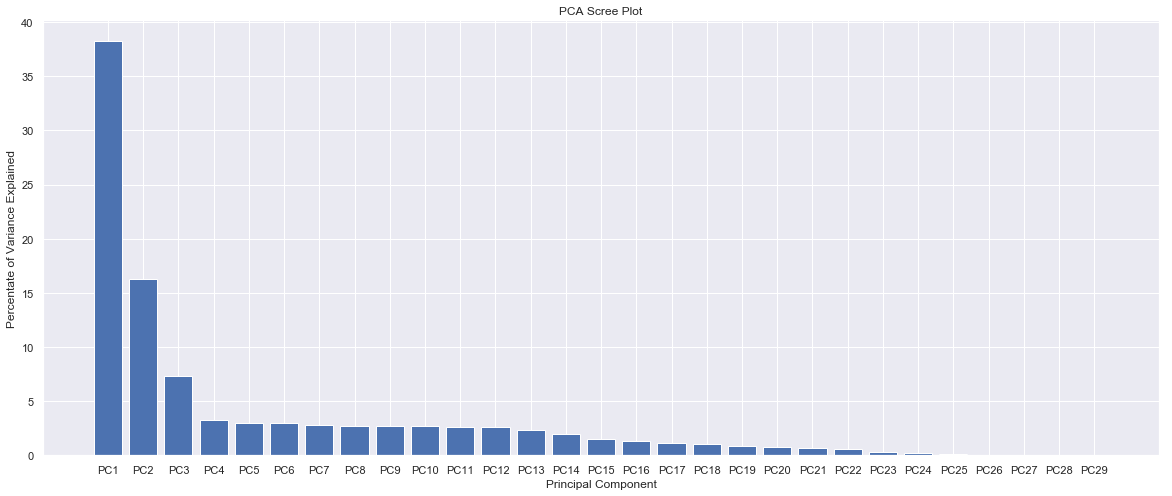

In [178]:
sns.set()
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
plt.figure(figsize=(20,8))
plt.bar(x= range(1,30), height=percent_variance, tick_label=pca_columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')

plt.show()

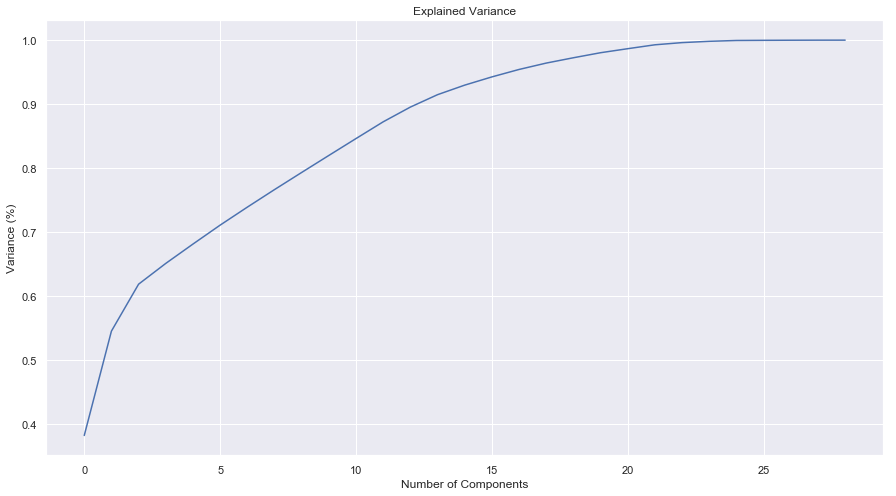

In [177]:
plt.figure(figsize = (15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()

In [174]:
#examine the components
pc1 = pca.components_[0]
pc2 = pca.components_[1] 
pc3 = pca.components_[2] 
pc4 = pca.components_[3] 
pc5 = pca.components_[4] 
pc6 = pca.components_[5] 
pc7 = pca.components_[6] 
pc8 = pca.components_[7] 
pc9 = pca.components_[8] 
pc10 = pca.components_[9] 
pc11 = pca.components_[10] 
pc12 = pca.components_[11] 
pc13 = pca.components_[12] 
pc14 = pca.components_[13] 
pc15 = pca.components_[14] 
pc16 = pca.components_[15] 
pc17 = pca.components_[16] 
pc18 = pca.components_[17] 
pc19 = pca.components_[18] 

In [161]:
# print(pc1)
# print(pc2)
# print(pc3)
# print(pc4)
# print(pc5)
# print(pc6)
# print(pc7)
# print(pc8)
# print(pc9)
# print(pc10)
# print(pc11)
# print(pc12)
# print(pc13)
# print(pc14)
# print(pc15)
# print(pc16)
# print(pc17)
# print(pc18)
# print(pc19)

In [179]:
# get the loadings
structure_loading_1 = pc1* np.sqrt(eig_values[0])
str_loading_1 = pd.Series(structure_loading_1, index=features)
str_loading_1.sort_values(ascending = False)

concave_points                 0.990366
mean_concave_points            0.984185
mean_smoothness                0.975562
symmetry                       0.972049
smoothness                     0.965159
mean_symmetry                  0.958600
mean_area                      0.958360
mean_perimeter                 0.945522
area                           0.944955
perimeter                      0.944768
fractal_dimension              0.931132
mean_fractal_dimension         0.894428
compactness                    0.800280
mean_compactness               0.221482
Bare Nuclei_1                  0.202374
Bare Nuclei_6                  0.052180
Bare Nuclei_2                  0.000809
Bare Nuclei_5                 -0.008071
Bare Nuclei_4                 -0.010973
Bare Nuclei_8                 -0.044460
Bare Nuclei_3                 -0.045866
Bare Nuclei_9                 -0.047939
Uniformity of Cell Size       -0.062571
Bare Nuclei_7                 -0.062620
Bland Chromatin               -0.073534


In [188]:
type(target_train)

pandas.core.series.Series

In [190]:
pc_to_drop = ['PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28',
       'PC29']
pca_train_df = principalDF.drop(pc_to_drop, axis = 1)

In [191]:
pca_train_df.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19'],
      dtype='object')

In [192]:
pca_test_df = testprincipalDF.drop(pc_to_drop, axis = 1)

In [193]:
pca_test_df.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19'],
      dtype='object')

[(2.0, 340), (4.0, 340)]


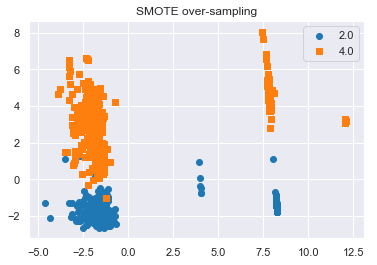

In [196]:

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(pca_train_df, target_train)
print(sorted(Counter(y_sm).items()))

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

In [ ]:
tpot = TPOTClassifier(generations=50, population_size= 50, cv = 10, verbosity= 2, n_jobs= 1)
tpot.fit(X_sm,y_sm)

Generation 1 - Current best internal CV score: 0.9779411764705882
Generation 2 - Current best internal CV score: 0.9779411764705882
Generation 3 - Current best internal CV score: 0.9779411764705882
Generation 4 - Current best internal CV score: 0.9779411764705882
Generation 5 - Current best internal CV score: 0.9779411764705882
Generation 6 - Current best internal CV score: 0.9794117647058824
Generation 7 - Current best internal CV score: 0.9794117647058824
Generation 8 - Current best internal CV score: 0.9794117647058824
Generation 9 - Current best internal CV score: 0.9794117647058824
